In [10]:
import pickle as pkl
from opt.mc_sim import *
import time
from common.variables import *
from opt.eval_policy import *

filename = "output/msource_value_dic_12-18-2022-14-41-23.pkl"

with open(filename, 'rb') as f:
    output_obj = pkl.load(f)

value_dic = output_obj["state_value_dic"]
model_params = output_obj["model_params"]
sourcingEnv = output_obj["mdp_env"]

# sourcingEnv2 = SourcingEnv(
#     lambda_arrival = model_params['mdp_env_params']['lambda'], # or 10
#     procurement_cost_vec = np.array(model_params['mdp_env_params']['procurement_cost_vec']),

#     supplier_lead_times_vec = np.array(model_params['mdp_env_params']['supplier_lead_times_vec']),
#     on_times = np.array(model_params['mdp_env_params']['on_times']), 
#     off_times = np.array(model_params['mdp_env_params']['off_times']),
#     fixed_costs = np.array(model_params['mdp_env_params']['fixed_costs'])) # np.array([np.Inf, np.Inf])) 

sourcingEnv2 = sourcingEnv

s_custom = MState(stock_level = 0, 
    n_suppliers = N_SUPPLIERS, 
    n_backorders = np.array([0, 0]), 
    flag_on_off = np.array([1, 1]))

In [11]:
if 'pol_dic' in output_obj: 
    output_obj['pol_dic']
    action = eval_policy_from_policy_dic(sourcingEnv2, pol_dic = output_obj['pol_dic'])
    action

In [12]:
sourcingEnv2.lambda_arrival

50

In [13]:
model_params["branch_name"], model_params["git_commit"]

('larkin/unif-pol-dic', '9c6e4cf0ffad9fcee9e0e401af56569148621e13')

In [14]:
# sourcingEnv2.lambda_arrival = 100
kwargs = {"periods" : 60,
    "nested_mc_iters" : 5,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty" : model_params['policy_params']['b_penalty'],
    "supplier_index": 1,
    "h_cost": 2,
    "b_penalty": 10
}

In [15]:
dummy_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        periods = 100,
        nested_mc_iters = 30,
        big_s = model_params['policy_params']['big_s'],
        small_s = model_params['policy_params']['small_s'],
        h_cost = model_params['policy_params']['h_cost'],
        b_penalty = model_params['policy_params']['b_penalty'],
        max_order = 6, # BIG_S,
        policy_callback=dummy_explore_policy,
        use_tqdm = True
    )

print(np.mean(dummy_cost))
print(np.median(np.array(dummy_cost)))
print(np.std(np.array(dummy_cost)))

100%|██████████| 30/30 [00:01<00:00, 22.49it/s]

5.3239694600928145
5.2641111022830405
0.8252992855568159


In [16]:
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 6, # BIG_S,
    policy_callback=dual_index_policy,
    use_tqdm = True
)


print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

100%|██████████| 30/30 [01:13<00:00,  2.45s/it]

4.900455466774562
4.89365449634286
0.8676144952934355


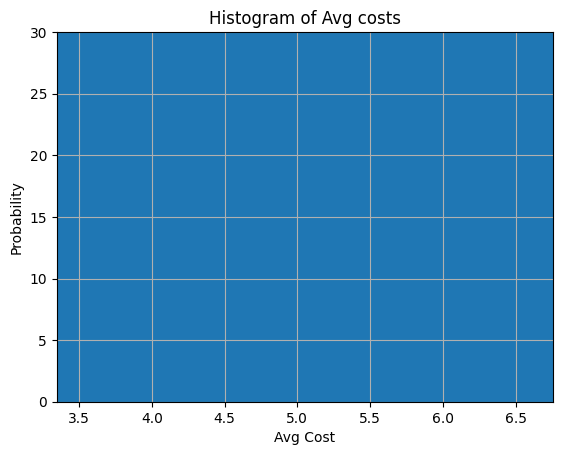

In [17]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange( np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [18]:
# sourcingEnv2.lambda_arrival = 50
# sourcingEnv2.supplier_lead_times_vec = np.array([0.008, 0.04])

model_params['mdp_env_params']

{'lambda': 50,
 'max_inven': 30,
 'action_size': 3,
 'discount_fac': 1.0,
 'procurement_cost_vec': [15, 5],
 'supplier_lead_times_vec': [0.036, 0.4],
 'on_times': [5, 1],
 'off_times': [0.5, 1],
 'fixed_costs': [0, 0]}

In [19]:
# output_obj['adp_cost'], output_obj['approx_di_cost'], output_obj['ss_cost']

In [20]:
mc_avg_costs_ss = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 100,
    policy_callback = ss_policy_fastest_supp_backlog,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_ss)))
print(np.median(np.array(mc_avg_costs_ss)))
print(np.std(np.array(mc_avg_costs_ss)))

100%|██████████| 100/100 [00:07<00:00, 12.71it/s]

6.295096157862472
6.05426646223491
1.7335632611131866


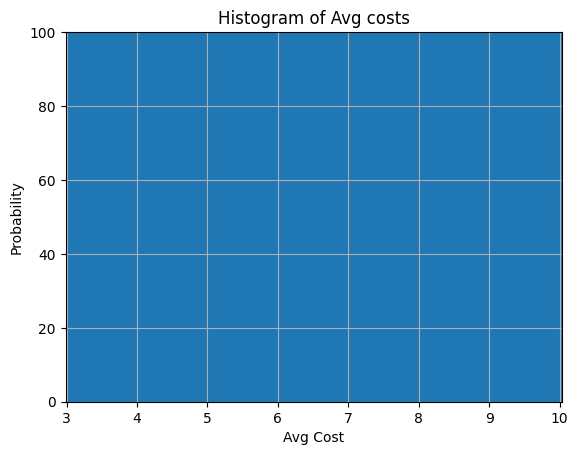

In [21]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_ss, bins=np.arange( np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_ss), np.max(mc_avg_costs_ss))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [22]:
# import matplotlib.pyplot as plt

# costs, avg_cost_per_period = mc_episode_with_policy(sourcingEnv2, policy = ss_policy_fastest_supp_backlog, periods = 1000,
#     nested_mc_iters = 100,
#     policy_callback = ss_policy_fastest_supp_backlog,
#     big_s = model_params['policy_params']['big_s'],
#     small_s = model_params['policy_params']['small_s'],
#     h_cost = model_params['policy_params']['h_cost'],
#     b_penalty = model_params['policy_params']['b_penalty'],
#     use_tqdm = True)

# # costs
# plt.plot(costs)

In [23]:
single_supplier_mean_costs = []
sing_supp_mean_cost = np.Inf
for s in range(sourcingEnv2.n_suppliers):

    kwargs = {"periods" : 100,
        "nested_mc_iters" : 100,
        "h_cost": model_params['policy_params']['h_cost'],
        "b_penalty" : model_params['policy_params']['b_penalty'],
        "supplier_index": s
    }

    single_supplier_costs = mc_with_policy(sourcingEnv2, start_state = s_custom, 
        use_tqdm = True,
        policy_callback = single_source_orderupto_policy,
        **kwargs)
    
    sing_supp_mean_cost_i = np.mean(single_supplier_costs)
    single_supplier_mean_costs.append(sing_supp_mean_cost_i)
    if sing_supp_mean_cost_i < sing_supp_mean_cost:
        single_supplier_costs_select = single_supplier_costs
        sing_supp_mean_cost = sing_supp_mean_cost_i

print(single_supplier_mean_costs)
print(np.min(single_supplier_mean_costs))

100%|██████████| 100/100 [00:10<00:00,  9.65it/s]

[6.672353088578043, 5.069621083537163]
5.069621083537163


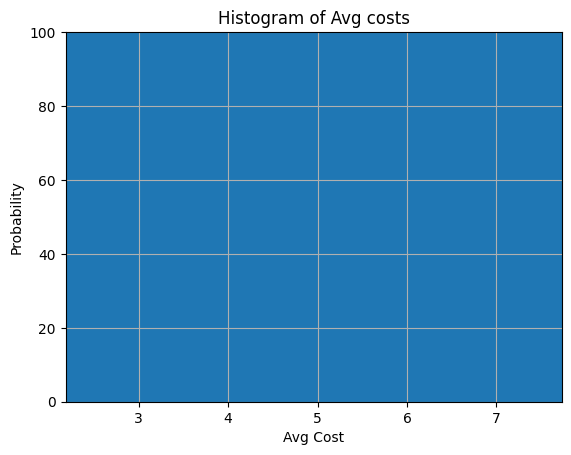

In [24]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(single_supplier_costs_select, bins=np.arange( np.min(single_supplier_costs_select), np.max(single_supplier_costs_select) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(single_supplier_costs_select), np.max(single_supplier_costs_select))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [25]:
from sim.dual_index_v1 import *
mc_avg_costs_di = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 30,
    nested_mc_iters = 30,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    policy_callback=dual_index_policy_v1,
    use_tqdm = True)

print(np.mean(np.array(mc_avg_costs_di)))
print(np.median(np.array(mc_avg_costs_di)))
print(np.std(np.array(mc_avg_costs_di)))

100%|██████████| 30/30 [00:03<00:00,  9.85it/s]

5.983506180454435
5.273013522385295
1.9255675528047984


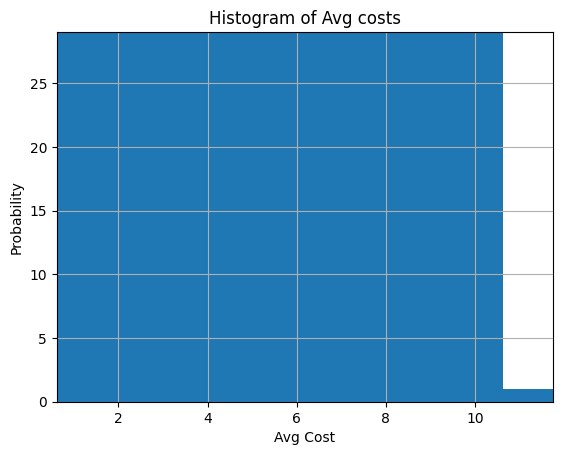

In [26]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(mc_avg_costs_di, bins=np.arange(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)


plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs_di), np.max(mc_avg_costs_di))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [40]:
myopic_cost = mc_with_policy(sourcingEnv2, start_state = s_custom, 
    periods = 100,
    nested_mc_iters = 3,
    big_s = model_params['policy_params']['big_s'],
    small_s = model_params['policy_params']['small_s'],
    h_cost = model_params['policy_params']['h_cost'],
    b_penalty = model_params['policy_params']['b_penalty'],
    max_order = 6, # BIG_S,
    policy_callback=myopic2_policy,
    use_tqdm = True)

print(np.mean(myopic_cost))
print(np.median(np.array(myopic_cost)))
print(np.std(np.array(myopic_cost)))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
myopic_cost

[9.024097992638396, 9.566412662878813, 8.61095040484901]

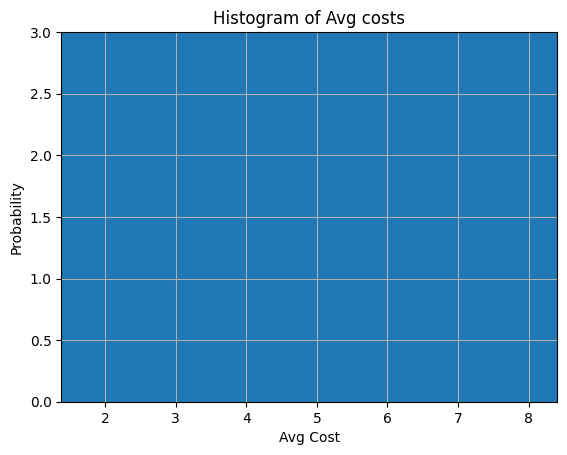

In [29]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 10
n, bins, patches = plt.hist(myopic_cost, bins=np.arange( np.min(myopic_cost), np.max(myopic_cost) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(myopic_cost), np.max(myopic_cost))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()

In [30]:
# kwargs = {
#     "value_dic": value_dic, 
#     "periods": 100, 
#     "periods_val_it": 3,
#     "nested_mc_iters": 3,
#     "max_stock": 3, # BIG_S,
#     "discount_fac": DISCOUNT_FAC,
#     "h_cost": model_params['policy_params']['h_cost'],
#     "b_penalty": model_params['policy_params']['b_penalty'],
#     "n_visit_lim": N_VISIT_LIM,
#     "default_ss_policy": ss_policy_fastest_supp_backlog,
#     "safe_factor": 1.1, #SAFE_FACTOR,
#     "sub_eval_periods": SUB_EVAL_PERIODS,
#     "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
#     "approx_eval": True
# }

# mc_avg_costs = mc_with_policy(sourcingEnv2, 
#     start_state = s_custom, 
#     use_tqdm = True,
#     policy_callback = eval_policy_from_value_dic,
#     **kwargs)

# print(np.mean(mc_avg_costs))
# print(np.median(mc_avg_costs))
# print(np.std(mc_avg_costs))

In [35]:
kwargs = {
    "value_dic": value_dic, 
    "periods": 100, 
    "periods_val_it": 1,
    "nested_mc_iters": 30,
    "max_stock": 2, # BIG_S,
    "discount_fac": DISCOUNT_FAC,
    "h_cost": model_params['policy_params']['h_cost'],
    "b_penalty": model_params['policy_params']['b_penalty'],
    "n_visit_lim": N_VISIT_LIM,
    "default_ss_policy": ss_policy_fastest_supp_backlog,
    "safe_factor": 1.1, #SAFE_FACTOR,
    "sub_eval_periods": SUB_EVAL_PERIODS,
    "sub_nested_mc_iter": SUB_NESTED_MC_ITER,
    "approx_eval": True,
    "pol_dic": output_obj['pol_dic']
}

mc_avg_costs = mc_with_policy(sourcingEnv2, 
    start_state = s_custom, 
    use_tqdm = True,
    policy_callback = eval_policy_from_policy_dic,
    **kwargs)

print(np.mean(mc_avg_costs))
print(np.median(mc_avg_costs))
print(np.std(mc_avg_costs))

100%|██████████| 30/30 [01:19<00:00,  2.64s/it]

4.910793002362888
4.5759043859022235
1.1773683508921424


In [36]:
mc_avg_costs

[3.924873404670763,
 4.559877009046639,
 4.7331704994580495,
 4.648161416358053,
 3.7133152622417196,
 4.214688334069856,
 6.749523191579261,
 4.995134546366986,
 4.308321434499427,
 4.919771508854803,
 7.2158682150067825,
 4.053585932218077,
 4.591931762757807,
 4.0472643491131315,
 4.181796941945915,
 4.180798729482067,
 4.618991167337169,
 4.518314974532736,
 4.457380103633115,
 3.927584639037849,
 7.032351158043209,
 4.893911209677119,
 3.7787238387058917,
 7.744205960939747,
 3.8090742333575434,
 3.6514856323491007,
 5.295696494013945,
 4.98111088180785,
 7.664310349398172,
 5.912566890383844]

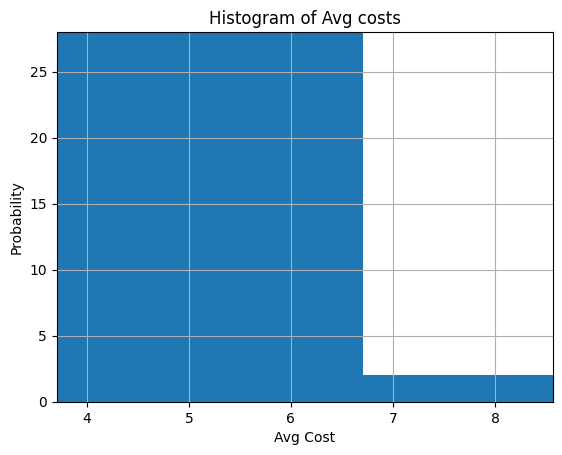

In [33]:
import matplotlib.pyplot as plt
import numpy as np

binwidth = 3
n, bins, patches = plt.hist(mc_avg_costs, bins=np.arange( np.min(mc_avg_costs) - binwidth, np.max(mc_avg_costs) + binwidth, binwidth))
# n, bins, patches = plt.hist(mc_avg_costs, density = True)

plt.xlabel('Avg Cost')
plt.ylabel('Probability')
plt.title('Histogram of Avg costs')
plt.xlim(np.min(mc_avg_costs), np.max(mc_avg_costs))
plt.ylim(0, np.max(n))
plt.grid(True)
plt.show()